<a href="https://colab.research.google.com/github/Mauricioscardoso/mauriciocase/blob/main/Script_Teste_ifood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KPIs Financeiros (ROI)

Setup e Importação de pacotes

In [ ]:
!apt-get update -qq
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("iFood_AB_Test")
    .getOrCreate()
)



!pip install lifelines -q

from pyspark.sql.functions import (
    hour, dayofweek, isnan, col, countDistinct, to_date, min as spark_min,
    datediff, avg, count, when, trim, sum as spark_sum
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from pyspark.sql import SparkSession



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Importação Direta dos Dados

In [ ]:
!wget -q https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz -O order.json.gz
!wget -q https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz -O consumer.csv.gz
!wget -q https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz -O restaurant.csv.gz
!wget -q https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz -O ab_test_ref.tar.gz

!tar -xvf ab_test_ref.tar.gz > /dev/null

orders = spark.read.json("order.json.gz")
consumers = spark.read.csv("consumer.csv.gz", header=True, inferSchema=True)
restaurants = spark.read.csv("restaurant.csv.gz", header=True, inferSchema=True)
ab_test = spark.read.csv("ab_test_ref.csv", header=True, inferSchema=True)


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'


Filtragem para Teste A/B

In [ ]:
orders_selected = orders.select(
    "order_id", "customer_id", "order_total_amount", "order_created_at", "merchant_id"
)
orders_ab = orders_selected.join(ab_test, on="customer_id", how="inner")
from pyspark.sql.functions import to_timestamp
orders_ab = orders_ab.withColumn("order_created_at", to_timestamp("order_created_at"))



Análise Exploratória


[EDA] Tipos de variáveis:
 customer_id                   object
order_id                      object
order_total_amount           float64
order_created_at      datetime64[ns]
merchant_id                   object
is_target                     object
dia_semana                     int32
hora                           int32
dtype: object

[EDA] Estatísticas:
        order_total_amount               order_created_at     dia_semana  \
count       182716.000000                         182716  182716.000000   
mean            48.373106  2019-01-07 02:39:49.399636224       2.918551   
min              0.000000            2018-12-03 00:00:08       0.000000   
25%             26.900000  2018-12-24 19:10:49.249999872       1.000000   
50%             39.800000            2019-01-09 22:00:25       3.000000   
75%             57.000000  2019-01-21 00:08:55.750000128       5.000000   
max         138750.900000            2019-01-31 23:59:44       6.000000   
std            326.299839               

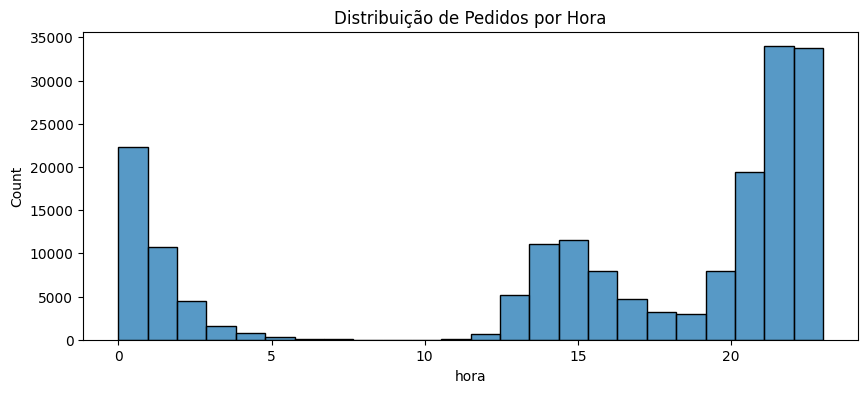

In [ ]:
eda_df = orders_ab.sample(fraction=0.05, seed=42).toPandas()
eda_df["order_created_at"] = pd.to_datetime(eda_df["order_created_at"])
eda_df["dia_semana"] = eda_df["order_created_at"].dt.dayofweek
eda_df["hora"] = eda_df["order_created_at"].dt.hour

print("\n[EDA] Tipos de variáveis:\n", eda_df.dtypes)
print("\n[EDA] Estatísticas:\n", eda_df.describe())
print("Mediana ticket:", eda_df["order_total_amount"].median())
print("\n[EDA] Nulos:\n", eda_df.isnull().sum())

plt.figure(figsize=(10,4))
sns.histplot(eda_df["hora"], bins=24)
plt.title("Distribuição de Pedidos por Hora")
plt.show()

# Intervalos de confiança (95%)
def ic_95(x):
    m = x.mean(); h = sem(x) * t.ppf(0.975, len(x)-1)
    return m-h, m+h

target = eda_df[eda_df.is_target == "target"]["order_total_amount"].dropna()
control = eda_df[eda_df.is_target == "control"]["order_total_amount"].dropna()

print("\n[IC-95] Target:", ic_95(target))
print("[IC-95] Controle:", ic_95(control))

KPIs por Grupo (Controle x Target)


[KPI] Resumo:
   is_target  total_pedidos  ticket_medio  receita_total  usuarios_unicos
0   control        1525576     47.897891   7.307187e+07           360542
1    target        2136745     47.739702   1.020076e+08           445924


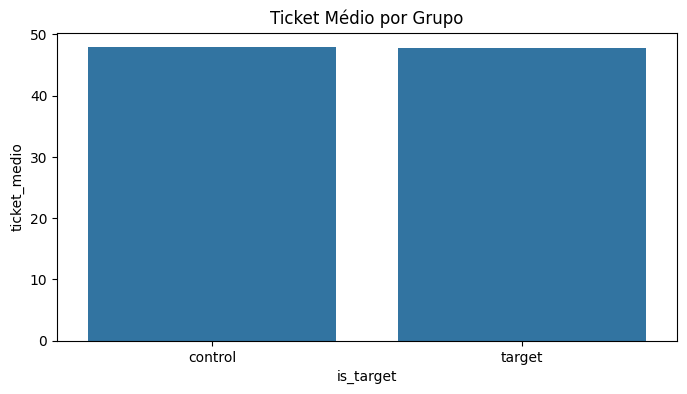


 Justificativa dos KPIs Escolhidos
• total_pedidos   → volume de transações gerado pela campanha.
• ticket_medio    → mudança de comportamento de gasto por pedido.
• receita_total   → impacto financeiro bruto.
• usuarios_unicos → escala da campanha e cálculo de retenção.
• ROI             → viabilidade financeira após custo do cupom.
• retenção        → fidelização de usuários além da 1ª compra.



In [ ]:
summary = orders_ab.groupBy("is_target").agg(
    count("order_id").alias("total_pedidos"),
    avg("order_total_amount").alias("ticket_medio"),
    spark_sum("order_total_amount").alias("receita_total"),
    countDistinct("customer_id").alias("usuarios_unicos")
)
summary_pd = summary.toPandas()
print("\n[KPI] Resumo:\n", summary_pd)

# Visualização
plt.figure(figsize=(8,4))
sns.barplot(data=summary_pd, x="is_target", y="ticket_medio")
plt.title("Ticket Médio por Grupo")
plt.show()
print("""
 Justificativa dos KPIs Escolhidos
• total_pedidos   → volume de transações gerado pela campanha.
• ticket_medio    → mudança de comportamento de gasto por pedido.
• receita_total   → impacto financeiro bruto.
• usuarios_unicos → escala da campanha e cálculo de retenção.
• ROI             → viabilidade financeira após custo do cupom.
• retenção        → fidelização de usuários além da 1ª compra.
""")

Retenção de Clientes

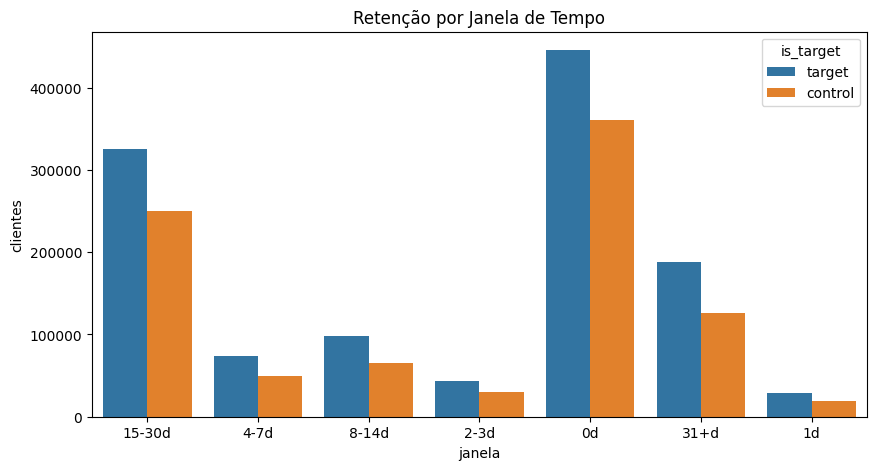

In [ ]:
primeira = orders_ab.withColumn("data", to_date("order_created_at"))\
    .groupBy("customer_id").agg(spark_min("data").alias("primeira"))
retencao = orders_ab.withColumn("data", to_date("order_created_at"))\
    .join(primeira, "customer_id")\
    .withColumn("dias_desde_primeira", datediff(col("data"), col("primeira")))\
    .withColumn("janela", when(col("dias_desde_primeira")<=0,"0d")\
                          .when(col("dias_desde_primeira")<=1,"1d")\
                          .when(col("dias_desde_primeira")<=3,"2-3d")\
                          .when(col("dias_desde_primeira")<=7,"4-7d")\
                          .when(col("dias_desde_primeira")<=14,"8-14d")\
                          .when(col("dias_desde_primeira")<=30,"15-30d")\
                          .otherwise("31+d"))
ret_pd = retencao.groupBy("is_target","janela").agg(countDistinct("customer_id").alias("clientes")).toPandas()
plt.figure(figsize=(10,5))
sns.barplot(data=ret_pd, x="janela", y="clientes", hue="is_target")
plt.title("Retenção por Janela de Tempo")
plt.show()


Testes Estatísticos

In [ ]:
from scipy.stats import shapiro, normaltest, mannwhitneyu

# Amostras até 5 000 registros para Shapiro‑Wilk
sample_target  = target.sample(n=min(5000, len(target)),  random_state=42)
sample_control = control.sample(n=min(5000, len(control)), random_state=42)
print("Normalidade – Shapiro‑Wilk")
for label, arr in zip(["Target", "Control"], [sample_target, sample_control]):
    w, p = shapiro(arr)
    print(f"{label}: W={w:.4f}, p={p:.4f} → {'normal' if p>0.05 else 'não normal'}")

print("Normalidade – D’Agostino & Pearson")
for label, arr in zip(["Target", "Control"], [target, control]):
    k2, p = normaltest(arr)
    print(f"{label}:  stat={k2:.2f}, p={p:.4f} → {'normal' if p>0.05 else 'não normal'}")

#  Teste não paramétrico – Mann–Whitney U
from scipy.stats import mannwhitneyu

# Amostras dos grupos target e control já definidos
target = eda_df[eda_df.is_target == "target"]["order_total_amount"].dropna()
control = eda_df[eda_df.is_target == "control"]["order_total_amount"].dropna()

# Executar teste
stat_u, p_u = mannwhitneyu(target, control, alternative="two-sided")

# Exibir resultado
print(f"[Mann–Whitney U] U = {stat_u:.0f}, p = {p_u:.4f}")
if p_u < 0.05:
    print("→ Diferença estatisticamente significativa entre os grupos.")
else:
    print("→ Não há diferença estatística significativa entre os grupos.")


# Teste t Ticket Médio
t_stat,p_val = ttest_ind(
    eda_df[eda_df.is_target=="target"]["order_total_amount"],
    eda_df[eda_df.is_target=="control"]["order_total_amount"],
    equal_var=False
)
print(f"\n[Teste t] t={t_stat:.2f}, p={p_val:.4f}")

# ANOVA dia da semana
anova_res = f_oneway(*[g["order_total_amount"].dropna() for _,g in eda_df.groupby("dia_semana")])
print(f"[ANOVA DiaSemana] F={anova_res.statistic:.2f}, p={anova_res.pvalue:.4f}")

# Retenção χ²
ret_df = retencao.withColumn("retido", when(col("dias_desde_primeira")==0,0).otherwise(1)).select("is_target","retido").toPandas()
chi2, pchi, _, _ = chi2_contingency(pd.crosstab(ret_df["is_target"], ret_df["retido"]))
print(f"[χ² Retenção] χ²={chi2:.2f}, p={pchi:.4f}")

Normalidade – Shapiro‑Wilk
Target: W=0.6794, p=0.0000 → não normal
Control: W=0.7698, p=0.0000 → não normal
Normalidade – D’Agostino & Pearson
Target:  stat=104412.86, p=0.0000 → não normal
Control:  stat=408193.51, p=0.0000 → não normal
[Mann–Whitney U] U = 4048656682, p = 0.2740
→ Não há diferença estatística significativa entre os grupos.

[Teste t] t=-1.04, p=0.3004
[ANOVA DiaSemana] F=1.81, p=0.0920
[χ² Retenção] χ²=3679.92, p=0.0000


In [ ]:
qtd_target = summary_pd.loc[summary_pd.is_target=="target","usuarios_unicos"].values[0]
qtd_ctrl   = summary_pd.loc[summary_pd.is_target=="control","usuarios_unicos"].values[0]
receita_t  = summary_pd.loc[summary_pd.is_target=="target","receita_total"].values[0]
receita_c  = summary_pd.loc[summary_pd.is_target=="control","receita_total"].values[0]
receita_inc = receita_t - receita_c
custo_cupom = qtd_target*10
roi = (receita_inc - custo_cupom)/custo_cupom
print("\n[ROI] Receita incremental: R$", round(receita_inc,2),
      "| Custo cupons: R$", custo_cupom,
      "| ROI:", f"{roi:.2%}")



[ROI] Receita incremental: R$ 28935696.96 | Custo cupons: R$ 4459240 | ROI: 548.89%


Outliers


🔎 Outliers identificados: 10711 registros
  ▸ Limite inferior: R$ -18.25
  ▸ Limite superior: R$ 102.15


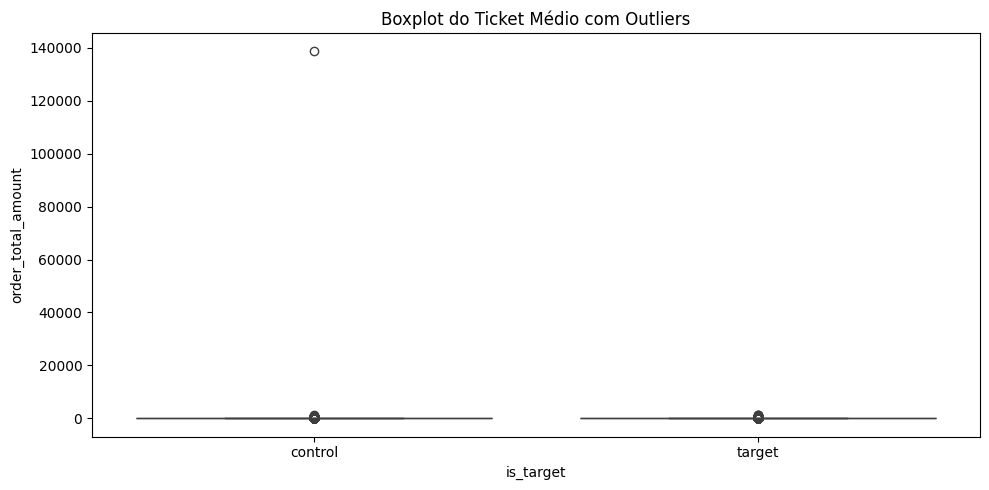

In [ ]:
q1 = eda_df["order_total_amount"].quantile(0.25)
q3 = eda_df["order_total_amount"].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers = eda_df[
    (eda_df["order_total_amount"] < limite_inferior) |
    (eda_df["order_total_amount"] > limite_superior)
]

print(f"\n🔎 Outliers identificados: {len(outliers)} registros")
print(f"  ▸ Limite inferior: R$ {limite_inferior:.2f}")
print(f"  ▸ Limite superior: R$ {limite_superior:.2f}")

# Gráfico para visualizar
plt.figure(figsize=(10, 5))
sns.boxplot(x="is_target", y="order_total_amount", data=eda_df, showfliers=True)
plt.title("Boxplot do Ticket Médio com Outliers")
plt.tight_layout()
plt.show()


Distribuição de Ticket

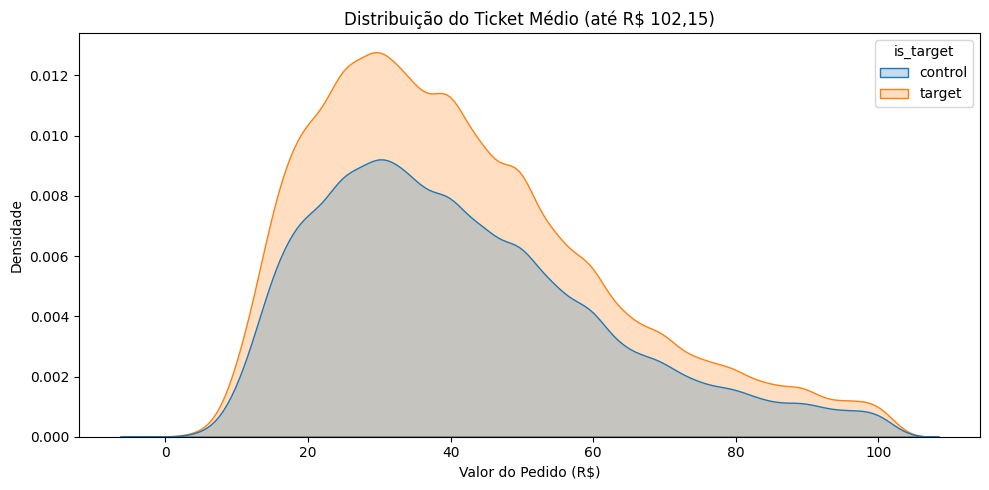

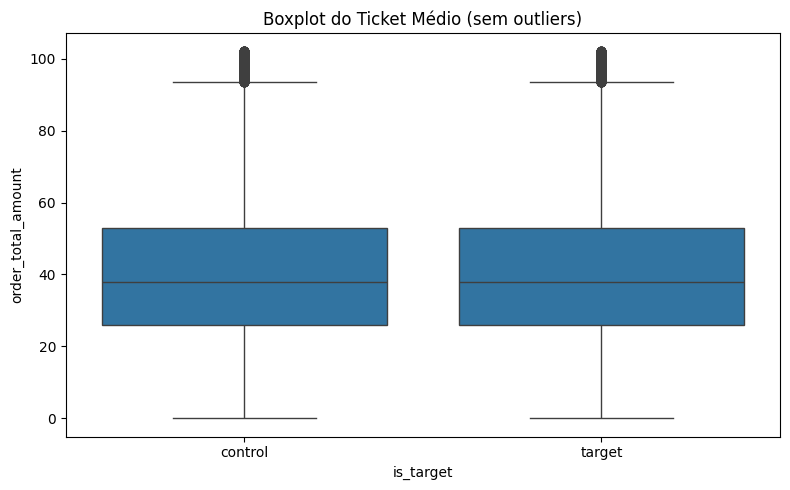

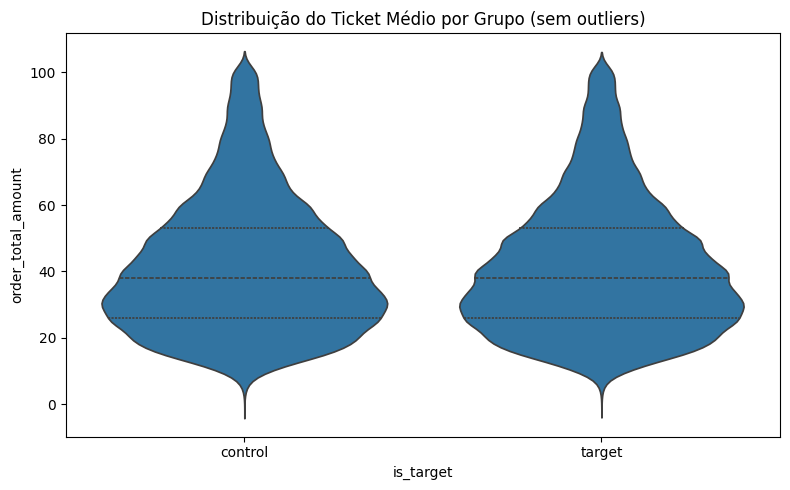

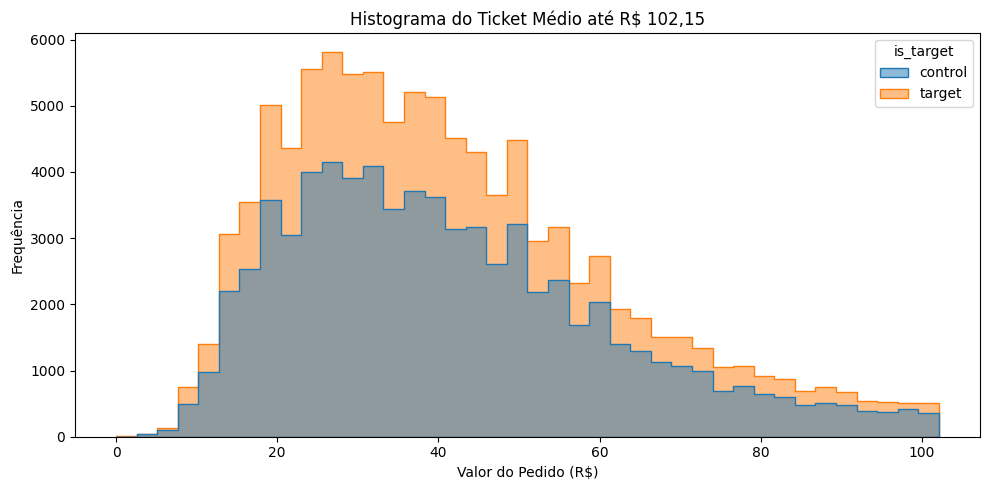

In [ ]:
# Visualizações sem Outliers (> R$ 102.15)
limite = 102.15
filtro = eda_df[eda_df["order_total_amount"] <= limite]

plt.figure(figsize=(10, 5))
sns.kdeplot(data=filtro, x="order_total_amount", hue="is_target", fill=True)
plt.title("Distribuição do Ticket Médio (até R$ 102,15)")
plt.xlabel("Valor do Pedido (R$)")
plt.ylabel("Densidade")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=filtro, x="is_target", y="order_total_amount")
plt.title("Boxplot do Ticket Médio (sem outliers)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(data=filtro, x="is_target", y="order_total_amount", inner="quartile")
plt.title("Distribuição do Ticket Médio por Grupo (sem outliers)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(data=eda_df[eda_df["order_total_amount"] <= 102.15],
             x="order_total_amount", hue="is_target", bins=40, element="step", stat="count", alpha=0.5)
plt.title("Histograma do Ticket Médio até R$ 102,15")
plt.xlabel("Valor do Pedido (R$)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

